In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 

In [3]:
pop_size = pd.read_csv('../../grenenet_cleaning/grenenet/pop_size_estimations.csv')

In [4]:
climate = pd.read_csv('../key_files/bioclimvars_experimental_sites_era5.csv')[['site', 'bio1']]

In [5]:
parallelism = pd.read_csv('../key_files/generation_1_parallelism.txt', sep ='\t')

In [6]:
pop_size['site_plot'] = pop_size['site'].astype(str) + '_' + pop_size['plot'].astype(str)

In [7]:
pop_size = pop_size[['totalplantnumber_complete','site_plot', 'generation']].pivot_table(index = 'site_plot', columns='generation', values ='totalplantnumber_complete').reset_index()

In [8]:
pop_size = pop_size[['site_plot', 1, 2, 3]]

In [9]:
pop_size[1].max()

820.0

In [10]:
pop_size[2].max()

661.2619928066763

In [11]:
pop_size[3].max()

468.6966872091277

In [12]:
df = pop_size.set_index('site_plot')

In [13]:
#df = df.head(10)

In [14]:
# Drop rows with more than 1 NaN
df_cleaned = df.dropna(thresh=2)  # thresh=2 keeps rows with at least 2 non-NaN values

# Independent variable (generations)
x = np.array([1, 2, 3])

# Extract site information from the index (e.g., '1_1' -> '1')
df_cleaned['site'] = df_cleaned.index.str.split('_').str[0]

/tmp/ipykernel_1677723/2735266357.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['site'] = df_cleaned.index.str.split('_').str[0]


In [15]:
df_cleaned[1].max()

622.1664367440837

In [16]:
df_cleaned[2].max()

661.2619928066763

In [17]:
df_cleaned[3].max()

468.6966872091277

In [18]:
# Group the DataFrame by 'site'
grouped = df_cleaned.groupby('site')

In [19]:
climate['site'] = climate['site'].astype(str)

In [20]:
import seaborn as sns

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

In [22]:
x_full = np.array([1, 2, 3])  # Generation values

grouped_sites_with_bio1 = pd.merge(df_cleaned[['site']], climate, on='site').drop_duplicates()

In [23]:


grouped_sites_with_bio1_sorted = grouped_sites_with_bio1.sort_values(by='bio1')

In [24]:
def fit_poly(group_long):

    # Prepare data
    x = group_long['Generation'].values.reshape(-1, 1)
    y = group_long['Population'].values
    # Step 1: Create polynomial features
    poly = PolynomialFeatures(degree=2)  # 2-degree polynomial
    x_poly = poly.fit_transform(x)  # Transform x into polynomial features
    
    # Step 2: Fit the model using LinearRegression (no ridge)
    model = LinearRegression()
    model.fit(x_poly, y)  # Fit the model
    
    # Step 3: Retrieve the coefficients and intercept
    intercept = model.intercept_  # This is the constant (c) term
    coefficients = model.coef_  # Coefficients for the polynomial terms
    # Step 4: Predict values for plotting
    x_fine = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    x_fine_poly = poly.transform(x_fine)  # Transform for polynomial features
    y_fine = model.predict(x_fine_poly)

    return model, x_fine, y_fine

def fit_lr(group_long):
    x = group_long['Generation'].values.reshape(-1, 1)
    y = group_long['Population'].values
    
    model = LinearRegression().fit(x, y)
    x_fine = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    y_fine = model.predict(x_fine)
    return model,x_fine, y_fine


In [25]:
colors = sns.color_palette('coolwarm', n_colors=27)


In [26]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def fit_poly_statsmodels(group_long):
    # Prepare data
    x = group_long['Generation'].values
    y = group_long['Population'].values
    # Step 1: Create polynomial features
    poly = PolynomialFeatures(degree=2)  # 2-degree polynomial
    x_poly = poly.fit_transform(x.reshape(-1, 1))  # Transform x into polynomial features
    
    # Step 2: Fit the model using OLS from statsmodels
    model = sm.OLS(y, x_poly).fit()  # Fit the model
    
    # Print the summary to see p-values and other statistics
    #print(model.summary())

    # Step 3: Predict values for plotting
    x_fine = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    x_fine_poly = poly.transform(x_fine)  # Transform for polynomial features
    y_fine = model.predict(x_fine_poly)

    return model, x_fine, y_fine

def fit_lr_statsmodels(group_long):
    # Prepare data
    x = group_long['Generation'].values.reshape(-1, 1)
    y = group_long['Population'].values

    # Add a constant term for the intercept to the predictor
    x_with_const = sm.add_constant(x)  # This adds the intercept

    # Fit the model using OLS from statsmodels
    model = sm.OLS(y, x_with_const).fit()
    #print(model.summary())  # This will print the summary with p-values

    # Generate x values for fine plotting, considering only the 'Generation' values
    x_fine = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_fine_with_const = sm.add_constant(x_fine)  # Add constant to fine x values

    # Predict y values based on fine x
    y_fine = model.predict(x_fine_with_const)

    return model, x_fine.flatten(), y_fine  # Return flattened x_fine for plotting



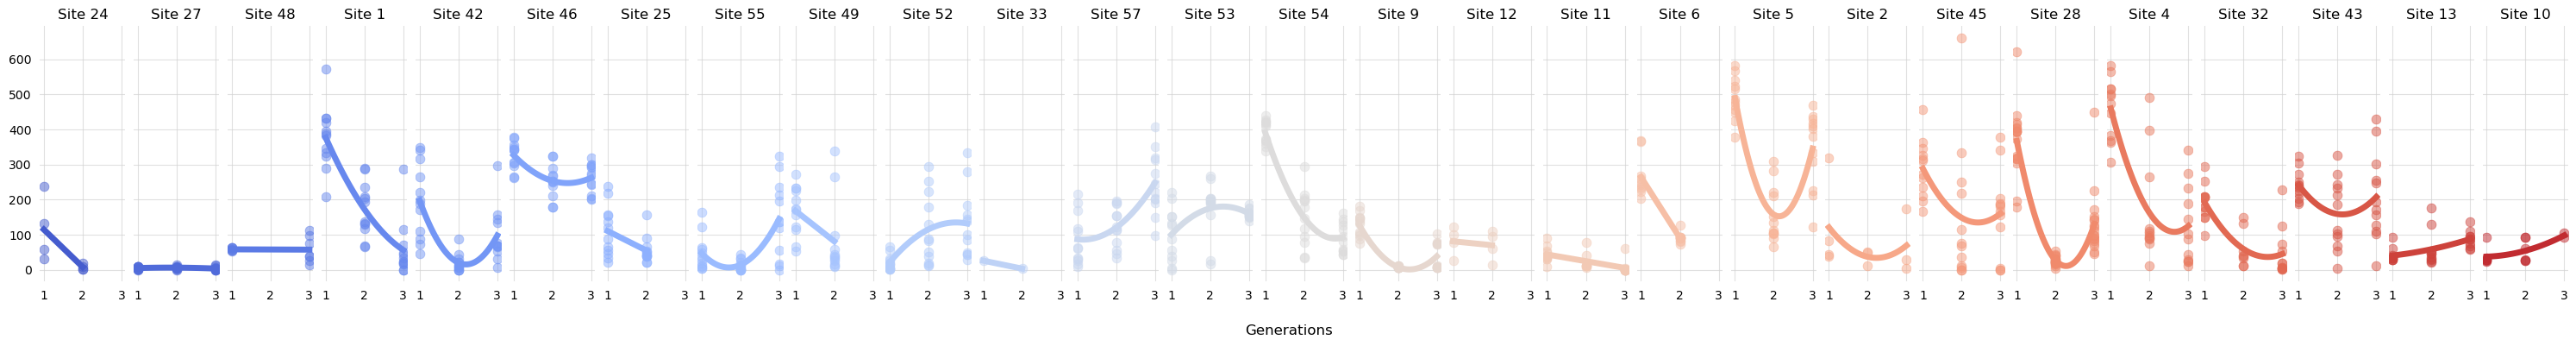

In [27]:
# Set up 3 rows and 9 columns for a total of 27 subplots (adjust to your total sites)

s_size=60
linewidth=5
alpha_scatter = 0.5
n_rows = 1
n_cols = 27
plt.rcParams['axes.axisbelow'] = True
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 4), sharex=True, sharey=True)  # 8x4 per plot, adjust as needed
axes = axes.flatten()  # Flatten the 2D axes array into 1D to easily iterate over

site_min_in_last_gen = {}
coeff_sites = {}
# Loop through each site to plot
for i, site in enumerate(grouped_sites_with_bio1_sorted['site']):
    group = df_cleaned[df_cleaned['site'] == site]

    # Reshape the data from wide to long format
    group_long = group.melt(var_name='Generation', value_name='Population', value_vars=[1, 2, 3], ignore_index=False)

    # Drop NaN values and ensure numeric types
    group_long = group_long.dropna()
    group_long['Generation'] = pd.to_numeric(group_long['Generation'])
    group_long['Population'] = pd.to_numeric(group_long['Population'])

    # Get the correct subplot
    ax = axes[i] if len(axes) > 1 else axes

    if group_long['Generation'].nunique() == 3:
        model, x_fine, y_fine = fit_poly_statsmodels(group_long)
        intercept = model.params[0]  # This is the constant (c) term
        coefficients = model.params  # Remaining coefficients
        pvalues = model.pvalues  # Remaining coefficients
        
        coeff_sites[site] = [len(group_long), intercept, coefficients[1:], pvalues]
        
        if (coefficients[1]<0) & (coefficients[2] > 0):
            ## evolutioanry rescue 
            sns.scatterplot(data=group_long, x='Generation', y='Population', ax=ax, color=colors[i], alpha =alpha_scatter, s = s_size, edgecolor=None,)
        # Plot
            ax.plot(x_fine, y_fine, color=colors[i],linewidth=linewidth)
            #ax.plot(x_fine, y_fine, color='black',linewidth=1.5)
        else:
            sns.scatterplot(data=group_long, x='Generation', y='Population', ax=ax, color=colors[i], alpha =alpha_scatter, s = s_size, edgecolor=None,)
        # Plot
            ax.plot(x_fine, y_fine,color=colors[i],linewidth=linewidth)

    elif group_long['Generation'].nunique() < 3:
        
        model, x_fine, y_fine = fit_lr_statsmodels(group_long)
        intercept = model.params[0]  # This is the constant (c) term
        coefficients = model.params  # Remaining coefficients
        pvalues = model.pvalues  # Remaining coefficients
        
        coeff_sites[site] = [len(group_long), intercept, coefficients[1:], pvalues]
        if (coefficients[0] > 0):
            ## evolutioanry rescue 
            sns.scatterplot(data=group_long, x='Generation', y='Population', ax=ax, color=colors[i], alpha = alpha_scatter, s = s_size, edgecolor=None,)
        # Plot
            ax.plot(x_fine, y_fine, color=colors[i],linewidth=linewidth)
        else:
            sns.scatterplot(data=group_long, x='Generation', y='Population', ax=ax,color=colors[i], alpha = alpha_scatter, s = s_size, edgecolor=None,)
        # Plot
            ax.plot(x_fine, y_fine, color=colors[i], linewidth=linewidth)


    # Remove spines (top and right)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)  # Also remove the left spine if you want to clean up more
    ax.spines['bottom'].set_visible(False)  # Also remove the bottom spine for a cleaner look
        # Remove ticks for all subplots except the first one

    # Add title and labels for each subplot
    bio1_value = int(grouped_sites_with_bio1_sorted.loc[grouped_sites_with_bio1_sorted["site"] == site, "bio1"].values[0])
    ax.set_title(f'Site {site}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('')
    ax.grid(True, color='lightgrey', alpha=0.7)
    ax.tick_params(axis='x', which='both',bottom=False)
    ax.tick_params(axis='y', which='both', left=False)
    ax.set_xlabel('')
fig.supxlabel('Generations')  # Set a common x-axis label for the entire figure

#plt.savefig('population_dynamics.png')
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce space between subplots horizontally and vertically
#plt.savefig('pop_dynamics_all_equal_statsmodel.png')
#plt.savefig('pop_dynamics_all_equal_pop_size_statsmodel.pdf')

In [28]:
len(group_long)

15

In [29]:
intercept

56.037812016590664

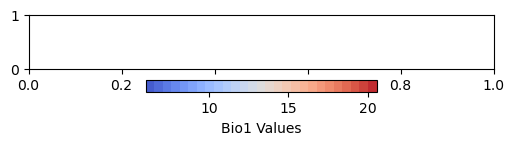

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd


# Generate color palette
colors = sns.color_palette('coolwarm', n_colors=27)

# Normalize bio1 values for color mapping
bio1_values = grouped_sites_with_bio1_sorted['bio1']
norm = mpl.colors.Normalize(vmin=bio1_values.min(), vmax=bio1_values.max())

# Create ScalarMappable
sm = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colors.ListedColormap(colors))
sm.set_array([])  # This is needed for the colorbar to acknowledge the ScalarMappable

# Plotting
fig, ax = plt.subplots(figsize=(6, 1))
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Bio1 Values')
plt.savefig('colorbar_pop_est.pdf')
plt.show()


In [31]:
coeff_sites

{'24': [8,
  144.76840035842665,
  array([-69.22225996]),
  array([0.04034852, 0.09634274])],
 '27': [34,
  0.29214950655171223,
  array([ 7.06209763, -1.97908619]),
  array([0.95937939, 0.27320147, 0.21206968])],
 '48': [14,
  34.30882954336626,
  array([7.64530538]),
  array([0.09972542, 0.39153472])],
 '1': [36,
  1131.4252632256312,
  array([-949.51146208,  195.00286552]),
  array([3.86693890e-16, 1.59714479e-12, 1.68222634e-10])],
 '42': [36,
  628.5622239316209,
  array([-558.31827598,  127.16576785]),
  array([2.14338698e-07, 1.39312019e-05, 4.58248832e-05])],
 '46': [36,
  309.8897765061679,
  array([-148.75146306,   28.09646013]),
  array([1.11492106e-15, 8.70156774e-07, 5.84575081e-05])],
 '25': [24,
  143.73935811066778,
  array([-66.09058242]),
  array([0.00012133, 0.00266202])],
 '55': [36,
  222.19053030235597,
  array([-270.82756912,   81.70642976]),
  array([0.01264238, 0.00784352, 0.00154567])],
 '49': [24,
  314.8866632412745,
  array([-151.99337014]),
  array([9.2752

In [32]:
combined_sites_data = {
    site: [n] + [intercept] + coefficients.tolist() + p_values.tolist()
    for site, (n, intercept, coefficients, p_values) in coeff_sites.items()
}

In [33]:
import pandas as pd
import numpy as np

# Prepare a list to convert into a DataFrame
data = []
for site, values in combined_sites_data.items():
    # Determine how many coefficients (half the length of the list)
    num_coeffs = len(values) // 2
    entry = {'site': site}
    if num_coeffs == 2:
        entry.update({
            'n': values[0],
            'intercept': values[1],
            'slope': values[2],
            'intercept_p': values[3],
            'slope_p': values[4],
            'quadratic': np.nan,
            'quadratic_p': np.nan
        })
    elif num_coeffs == 3:
        entry.update({
            'n': values[0],
            'intercept': values[1],
            'slope': values[2],
            'quadratic': values[3],
            'intercept_p': values[4],
            'slope_p': values[5],
            'quadratic_p': values[6]
        })
    data.append(entry)

# Create DataFrame
coeff_sitesdf = pd.DataFrame(data)




In [34]:
coeff_sitesdf = coeff_sitesdf.merge(climate)

In [35]:
#coeff_sitesdf.to_csv('population_dynamics_jan28.csv', index=None)

In [36]:
U-shape trajectories indicating evolutionary rescue (Fig. 2F, Fig. S8, across sites: N (t) ~ a +bt+ct2 ; 

c=37 P=3.03×10-5, n=670; example garden 32 Mallorca, Spain, c=102.65, P=0.0023, n=24). 
Together, the significant allele frequency shifts and the U-shape population size trajectories support the notion that adaptive evolution rescue occurred across climates.


SyntaxError: invalid syntax (3565832516.py, line 1)

In [37]:
coeff_sitesdf = pd.read_csv('population_dynamics_jan28.csv')

In [38]:
parallelism['site'] = parallelism['site'].astype(str)

In [39]:
parallelism_snps = parallelism[parallelism['source'] == 'snp']

parallelism_snps = parallelism_snps[['site', 'mean']]

parallelism_snps.columns = ['site', 'p_snps']

In [40]:
parallelism_ecotypes = parallelism[parallelism['source'] == 'ecotype']

parallelism_ecotypes = parallelism_ecotypes[['site', 'mean']]

parallelism_ecotypes.columns = ['site', 'p_ecotypes']

In [41]:
parallelism_ecotypes_forplot = parallelism_ecotypes[parallelism_ecotypes['site'].isin(grouped_sites_with_bio1_sorted['site'])]

In [42]:
parallelism_ecotypes_forplot.sort_values('p_ecotypes')['site'].values

array(['48', '27', '13', '2', '12', '28', '11', '55', '25', '24', '52',
       '57', '53', '10', '9', '1', '42', '45', '46', '6', '49', '54',
       '43', '4', '5', '32'], dtype=object)

In [43]:
len(parallelism_ecotypes)

30

In [51]:
coeff_sitesdf['site']

1     27
3      1
4     42
5     46
7     55
9     52
11    57
12    53
13    54
14     9
16    11
18     5
19     2
20    45
21    28
22     4
23    32
24    43
25    13
26    10
Name: site, dtype: int64

In [54]:
parallelism_snps['site'] = parallelism_snps['site'].astype(int)
parallelism_ecotypes['site'] = parallelism_ecotypes['site'].astype(int)


In [55]:
coeff_sitesdf = coeff_sitesdf.merge(parallelism_snps).merge(parallelism_ecotypes)

In [56]:
coeff_sitesdf

,site,n,intercept,slope,intercept_p,slope_p,quadratic,quadratic_p,bio1,p_snps,p_ecotypes
0,27,34,0.292150,7.062098,9.593794e-01,2.732015e-01,-1.979086,2.120697e-01,7.425145,-0.014482,-0.007645
1,1,36,1131.425263,-949.511462,3.866939e-16,1.597145e-12,195.002866,1.682226e-10,10.743906,0.399356,0.221854
2,42,36,628.562224,-558.318276,2.143387e-07,1.393120e-05,127.165768,4.582488e-05,10.927050,0.285304,0.241460
3,46,36,309.889777,-148.751463,1.114921e-15,8.701568e-07,28.096460,5.845751e-05,11.277027,0.558565,0.307219
4,55,36,222.190530,-270.827569,1.264238e-02,7.843517e-03,81.706430,1.545670e-03,11.564501,0.157314,0.071886
5,52,36,-10.937500,34.055556,7.730726e-01,4.310386e-01,-5.340278,6.167658e-01,12.005284,0.176809,0.099618
6,57,36,130.104196,-88.659848,4.874099e-02,2.280890e-01,31.555652,8.655114e-02,12.276481,0.206702,0.105076
7,53,36,16.460243,46.214032,7.115446e-01,3.631201e-01,-8.780212,4.838580e-01,12.362217,0.257256,0.110851
8,54,36,729.588962,-521.519714,1.648858e-15,3.025632e-10,98.945249,9.431590e-08,12.440169,0.684013,0.476094
9,9,36,275.038876,-241.983983,1.228213e-10,3.584842e-08,54.056218,2.654919e-07,12.481669,0.279275,0.158673


In [56]:
coeff_sitesdf.to_csv('../key_files/population_dynamics_jan28.csv', index=None)

In [9]:
coeff_sitesdf = pd.read_csv('../key_files/population_dynamics_jan28.csv')

In [11]:
coeff_sitesdf = coeff_sitesdf[coeff_sitesdf['site']!='57']

coeff_sitesdf = coeff_sitesdf[coeff_sitesdf['quadratic'].notna()]

coeff_sitesdf.sort_values('p_ecotypes').site.values

array([27, 13,  2, 28, 11, 55, 52, 57, 53, 10,  9,  1, 42, 45, 46, 54, 43,
        4,  5, 32])

In [12]:
coeff_sitesdf[coeff_sitesdf['quadratic'].notna()]

,site,n,intercept,slope,intercept_p,slope_p,quadratic,quadratic_p,bio1,p_snps,p_ecotypes
1,27,34,0.292150,7.062098,9.593794e-01,2.732015e-01,-1.979086,2.120697e-01,7.425145,-0.014482,-0.007645
3,1,36,1131.425263,-949.511462,3.866939e-16,1.597145e-12,195.002866,1.682226e-10,10.743906,0.399356,0.221854
4,42,36,628.562224,-558.318276,2.143387e-07,1.393120e-05,127.165768,4.582488e-05,10.927050,0.285304,0.241460
5,46,36,309.889777,-148.751463,1.114921e-15,8.701568e-07,28.096460,5.845751e-05,11.277027,0.558565,0.307219
7,55,36,222.190530,-270.827569,1.264238e-02,7.843517e-03,81.706430,1.545670e-03,11.564501,0.157314,0.071886
9,52,36,-10.937500,34.055556,7.730726e-01,4.310386e-01,-5.340278,6.167658e-01,12.005284,0.176809,0.099618
10,57,36,130.104196,-88.659848,4.874099e-02,2.280890e-01,31.555652,8.655114e-02,12.276481,0.206702,0.105076
11,53,36,16.460243,46.214032,7.115446e-01,3.631201e-01,-8.780212,4.838580e-01,12.362217,0.257256,0.110851
12,54,36,729.588962,-521.519714,1.648858e-15,3.025632e-10,98.945249,9.431590e-08,12.440169,0.684013,0.476094
13,9,36,275.038876,-241.983983,1.228213e-10,3.584842e-08,54.056218,2.654919e-07,12.481669,0.279275,0.158673


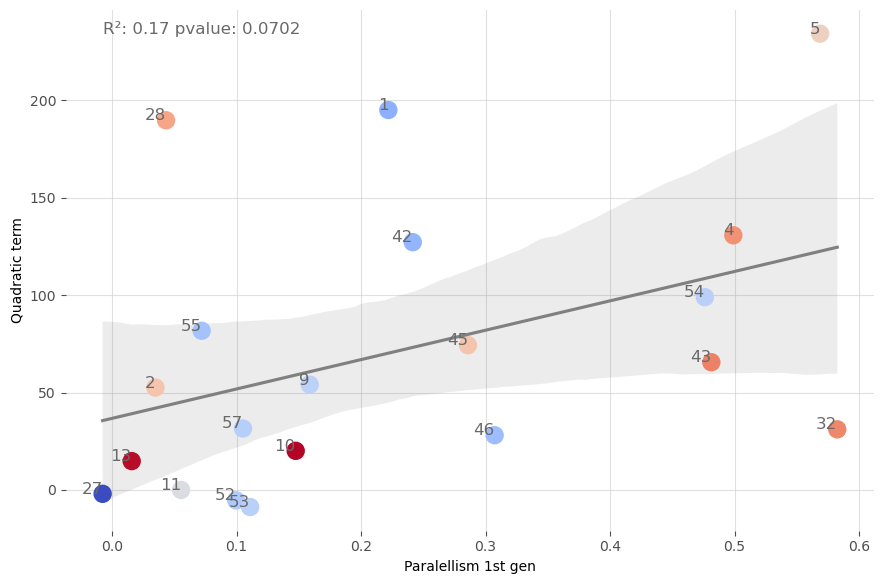

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


font_size = 12
# Assuming coeff_sitesdf is a DataFrame with columns 'site', 'p_ecotypes', 'cuadratic_term'
plt.rcParams['axes.axisbelow'] = True

# Perform linear regression using scipy to get slope, intercept, and R² value
x = coeff_sitesdf['p_ecotypes']
y = coeff_sitesdf['quadratic']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the scatter plot with seaborn
plt.figure(figsize=(9, 6))
sns.regplot(
    data=coeff_sitesdf, 
    x='p_ecotypes', 
    y='quadratic', 
    scatter=False,
    line_kws={'color': 'grey'}  # Color the regression line
)

sns.scatterplot(
    data=coeff_sitesdf, 
    x='p_ecotypes', 
    y='quadratic', 
    hue = 'bio1', 
    palette='coolwarm',
    edgecolor=None,
    s= 150,
    legend=False,
)

# Add labels for each site at the corresponding points
for i in range(coeff_sitesdf.shape[0]):
    site = coeff_sitesdf['site'].iloc[i]
    x_value = coeff_sitesdf['p_ecotypes'].iloc[i]
    y_value = coeff_sitesdf['quadratic'].iloc[i]
    plt.text(x_value, y_value, site, fontsize=12, ha='right', color = 'dimgray')  # ha='right' adjusts horizontal alignment

# Display the slope and R² on the plot
plt.text(min(x), max(y), f'R²: {r_value**2:.2f} pvalue: {p_value:.4f}', fontsize=12, color='dimgray')

## labels 
plt.ylabel('Quadratic term')
plt.xlabel('Paralellism 1st gen')

plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size

dark_grey = '#4D4D4D'  # Define dark grey color

# Apply to spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set tick parameters
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors
plt.grid(True, color='lightgrey', alpha=0.7)

# Adjust the layout and show the plot
plt.tight_layout()
#plt.savefig('parallelism_ecotypes_cuadratic_term.png')
#plt.savefig('parallelism_ecotypes_cuadratic_term.svg')


plt.show()




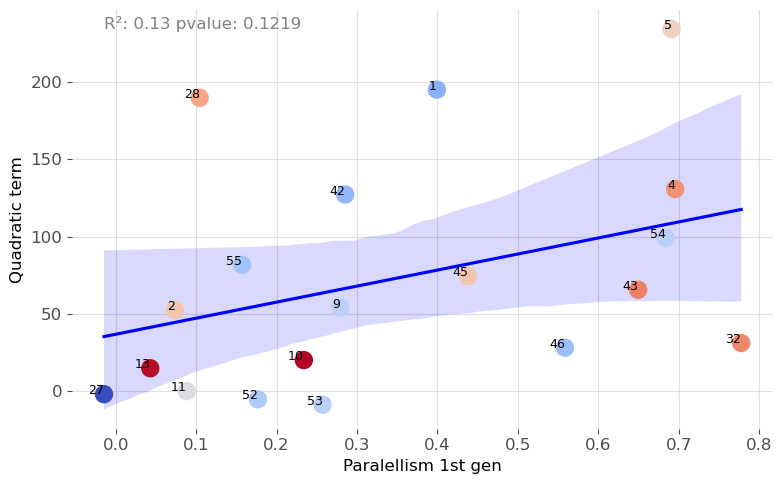

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


font_size = 12
# Assuming coeff_sitesdf is a DataFrame with columns 'site', 'p_ecotypes', 'cuadratic_term'
plt.rcParams['axes.axisbelow'] = True

# Perform linear regression using scipy to get slope, intercept, and R² value
x = coeff_sitesdf['p_snps']
y = coeff_sitesdf['quadratic']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the scatter plot with seaborn
plt.figure(figsize=(8, 5))
sns.regplot(
    data=coeff_sitesdf, 
    x='p_snps', 
    y='quadratic', 
    scatter=False,
    line_kws={'color': 'blue'}  # Color the regression line
)

sns.scatterplot(
    data=coeff_sitesdf, 
    x='p_snps', 
    y='quadratic', 
    hue = 'bio1', 
    palette='coolwarm',
    edgecolor=None,
    s= 150,
    legend=False,
)

# Add labels for each site at the corresponding points
for i in range(coeff_sitesdf.shape[0]):
    site = coeff_sitesdf['site'].iloc[i]
    x_value = coeff_sitesdf['p_snps'].iloc[i]
    y_value = coeff_sitesdf['quadratic'].iloc[i]
    plt.text(x_value, y_value, site, fontsize=9, ha='right')  # ha='right' adjusts horizontal alignment

# Display the slope and R² on the plot
plt.text(min(x), max(y), f'R²: {r_value**2:.2f} pvalue: {p_value:.4f}', fontsize=12, color='grey')

## labels 
plt.ylabel('Quadratic term')
plt.xlabel('Paralellism 1st gen')

plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size

dark_grey = '#4D4D4D'  # Define dark grey color

# Apply to spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set tick parameters
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors
plt.grid(True, color='lightgrey', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Adjust the layout and show the plot
plt.tight_layout()
#plt.savefig('parallelism_cuadratic_term.png')

plt.show()




In [ ]:
## population size against parallelism 

In [26]:
gen = 1 

In [27]:
pop_size

generation,site_plot,1,2,3
0,10_1,20.022046,76.024195,NaN
1,10_10,27.816165,NaN,94.001247
2,10_11,22.539866,NaN,NaN
3,10_12,14.278739,NaN,NaN
4,10_2,22.539866,53.751287,107.929843
...,...,...,...,...
390,9_5,78.333333,7.868034,8.548902
391,9_6,86.333333,9.158410,10.811135
392,9_7,87.666667,5.366662,67.658663
393,9_8,51.000000,7.868034,10.811135


In [29]:
pop_size_gen1  = pop_size[['site_plot', gen]]

pop_size_gen1['site']  = pop_size_gen1['site_plot'].str.split('_').str[0]

pop_size_gen1 = pop_size_gen1.groupby('site')[1].mean().reset_index()

/tmp/ipykernel_1148833/3938227580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_size_gen1['site']  = pop_size_gen1['site_plot'].str.split('_').str[0]


In [30]:
parallelism

,site,mean,lower,upper,generation,source
0,1,0.399356,0.369797,0.428495,1,snp
1,2,0.073612,0.014468,0.128584,1,snp
2,4,0.695603,0.680184,0.711607,1,snp
3,5,0.691080,0.633978,0.756238,1,snp
4,6,0.480042,0.425756,0.538647,1,snp
5,9,0.279275,0.248683,0.308896,1,snp
6,10,0.233950,0.174433,0.287781,1,snp
7,11,0.088494,0.058181,0.117339,1,snp
8,12,0.100474,0.071537,0.126819,1,snp
9,13,0.043040,0.018482,0.063527,1,snp


In [34]:
pop_size_gen1['site'] = pop_size_gen1['site'].astype(int)

In [35]:
parallelism_wpopsize = parallelism.merge(pop_size_gen1, on = 'site')

parallelism_wpopsize.columns = ['site', 'mean', 'lower', 'upper', 'generation', 'source', 'pop_size']

parallelism_wpopsize = parallelism_wpopsize.merge(climate)

parallelism_wpopsize_snps = parallelism_wpopsize[parallelism_wpopsize['source'] == 'snp']
parallelism_wpopsize_ecotypes = parallelism_wpopsize[parallelism_wpopsize['source'] == 'ecotype']

<Axes: xlabel='pop_size', ylabel='mean'>

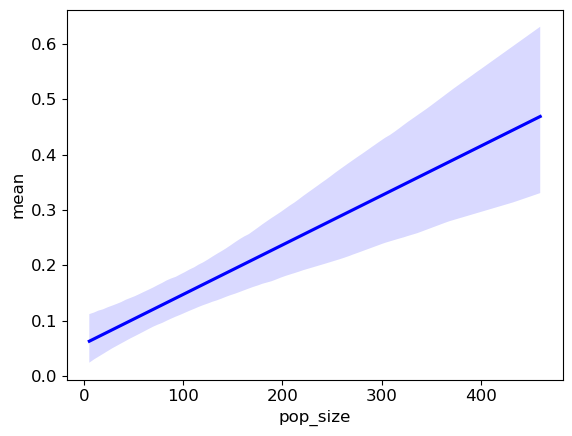

In [39]:
sns.regplot(
    data=parallelism_wpopsize_ecotypes, 
    x='pop_size', 
    y='mean', 
    scatter=False,
    line_kws={'color': 'blue'}  # Color the regression line
)

In [41]:
parallelism_wpopsize_ecotypes

,site,mean,lower,upper,generation,source,pop_size,bio1
1,1,0.221854,0.197582,0.244416,1,ecotype,376.916667,10.743906
3,2,0.034774,-0.011705,0.077576,1,ecotype,58.805556,15.594627
5,4,0.498951,0.478904,0.517680,1,ecotype,459.916667,17.513474
7,5,0.568639,0.527622,0.614460,1,ecotype,437.510797,14.996355
9,6,0.331436,0.293169,0.372643,1,ecotype,243.750000,14.989079
11,9,0.158673,0.126734,0.186057,1,ecotype,87.111111,12.481669
13,10,0.147432,0.084408,0.204503,1,ecotype,26.582792,20.550923
15,11,0.055337,0.023897,0.082457,1,ecotype,37.003124,13.801396
17,12,0.039891,0.011437,0.062650,1,ecotype,24.291667,12.957162
19,13,0.015694,-0.008322,0.034563,1,ecotype,31.241166,20.412710


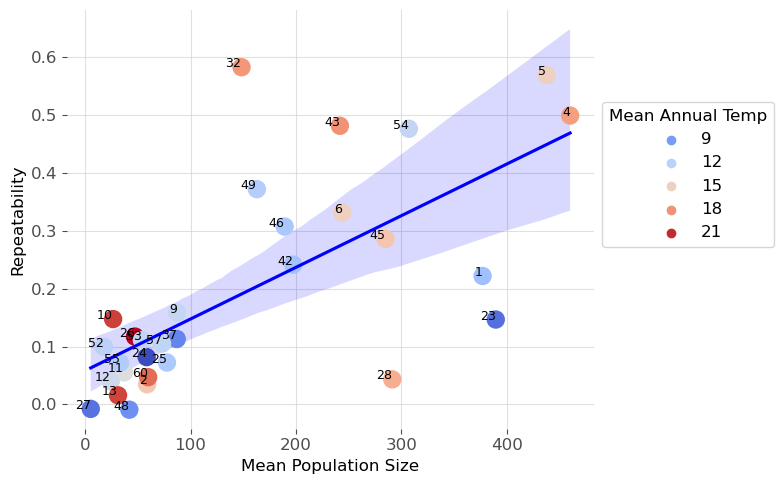

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


font_size = 12
# Assuming coeff_sitesdf is a DataFrame with columns 'site', 'p_ecotypes', 'cuadratic_term'
plt.rcParams['axes.axisbelow'] = True

# Perform linear regression using scipy to get slope, intercept, and R² value
x = parallelism_wpopsize_ecotypes['pop_size']
y = parallelism_wpopsize_ecotypes['mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the scatter plot with seaborn
plt.figure(figsize=(8, 5))
sns.regplot(
    data=parallelism_wpopsize_ecotypes, 
    x='pop_size', 
    y='mean', 
    scatter=False,
    line_kws={'color': 'blue'}  # Color the regression line
)

sns.scatterplot(
    data=parallelism_wpopsize_ecotypes, 
    x='pop_size', 
    y='mean', 
    hue = 'bio1', 
    palette='coolwarm',
    edgecolor=None,
    s= 150,
)

# Add labels for each site at the corresponding points
for i in range(parallelism_wpopsize_ecotypes.shape[0]):
    site = parallelism_wpopsize_ecotypes['site'].iloc[i]
    x_value = parallelism_wpopsize_ecotypes['pop_size'].iloc[i]
    y_value = parallelism_wpopsize_ecotypes['mean'].iloc[i]
    plt.text(x_value, y_value, site, fontsize=9, ha='right')  # ha='right' adjusts horizontal alignment

# Display the slope and R² on the plot
#plt.text(min(x), max(y), f'R²: {r_value**2:.2f} pvalue: {p_value:.6f}', fontsize=12, color='grey')

## labels 
plt.ylabel('Repeatability')
plt.xlabel('Mean Population Size')

plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size

dark_grey = '#4D4D4D'  # Define dark grey color

# Apply to spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set tick parameters
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors
plt.grid(True, color='lightgrey', alpha=0.7)

plt.legend(bbox_to_anchor=(1, 0.8), loc='upper left',     title='Mean Annual Temp',              # Title for the legend
)


# Adjust the layout and show the plot
plt.tight_layout()
plt.savefig('parallelism_ecotypes_pop_size.png')
plt.savefig('parallelism_ecotypes_pop_size.pdf')

plt.show()




In [71]:
print(slope, intercept, r_value, p_value, std_err)

533.3889152046112 48.3655022367095 0.6899521587863733 2.461220213520639e-05 105.75418277184332


In [ ]:
min(x), max(y), f'R²: {r_value**2:.2f} pvalue: {p_value:.6f}', fontsize=12, color='grey'

In [72]:
r_value**2

0.47603398141397685

In [73]:
p_value

2.461220213520639e-05

In [77]:
r_value**2

0.47603398141397685

In [78]:
gen = 3

pop_size_gen1  = pop_size[['site_plot', gen]]

pop_size_gen1 = pop_size_gen1.dropna()

In [79]:


pop_size_gen1['site']  = pop_size_gen1['site_plot'].str.split('_').str[0]

pop_size_gen1 = pop_size_gen1.groupby('site')[gen].mean().reset_index()

parallelism_wpopsize = parallelism.merge(pop_size_gen1, on = 'site')

parallelism_wpopsize.columns = ['site', 'mean', 'lower', 'upper', 'generation', 'source', 'pop_size']

parallelism_wpopsize = parallelism_wpopsize.merge(climate)

parallelism_wpopsize_snps = parallelism_wpopsize[parallelism_wpopsize['source'] == 'snp']
parallelism_wpopsize_ecotypes = parallelism_wpopsize[parallelism_wpopsize['source'] == 'ecotype']

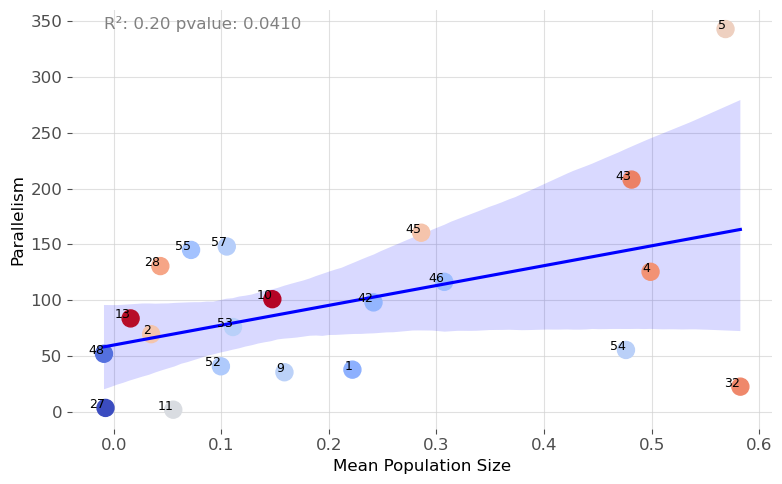

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


font_size = 12
# Assuming coeff_sitesdf is a DataFrame with columns 'site', 'p_ecotypes', 'cuadratic_term'
plt.rcParams['axes.axisbelow'] = True

# Perform linear regression using scipy to get slope, intercept, and R² value
x = parallelism_wpopsize_ecotypes['mean']
y = parallelism_wpopsize_ecotypes['pop_size']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the scatter plot with seaborn
plt.figure(figsize=(8, 5))
sns.regplot(
    data=parallelism_wpopsize_ecotypes, 
    x='mean', 
    y='pop_size', 
    scatter=False,
    line_kws={'color': 'blue'}  # Color the regression line
)

sns.scatterplot(
    data=parallelism_wpopsize_ecotypes, 
    x='mean', 
    y='pop_size', 
    hue = 'bio1', 
    palette='coolwarm',
    edgecolor=None,
    s= 150,
    legend=False,
)

# Add labels for each site at the corresponding points
for i in range(parallelism_wpopsize_ecotypes.shape[0]):
    site = parallelism_wpopsize_ecotypes['site'].iloc[i]
    x_value = parallelism_wpopsize_ecotypes['mean'].iloc[i]
    y_value = parallelism_wpopsize_ecotypes['pop_size'].iloc[i]
    plt.text(x_value, y_value, site, fontsize=9, ha='right')  # ha='right' adjusts horizontal alignment

# Display the slope and R² on the plot
plt.text(min(x), max(y), f'R²: {r_value**2:.2f} pvalue: {p_value:.4f}', fontsize=12, color='grey')

## labels 
plt.ylabel('Parallelism')
plt.xlabel('Mean Population Size')

plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size

dark_grey = '#4D4D4D'  # Define dark grey color

# Apply to spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set tick parameters
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors
plt.grid(True, color='lightgrey', alpha=0.7)

# Adjust the layout and show the plot
plt.tight_layout()
plt.savefig('parallelism_pop_size.png')

plt.show()


